# 1. Problem Overview

Predicting patient outcomes in the intensive care unit (ICU) is a critical challenge. Early identification of patients at high risk of mortality enables clinicians to prioritize interventions, allocate resources efficiently, and improve overall patient care. Machine learning and statistical modeling approaches can serve as powerful tools for improving outcome prediction as they can capture complex relationships and patterns inherent in patient data. 

However, due to the high dimensionality, missingness, and correlations present in ICU datasets, it is critical to develop models that balance predictive performance with interpretability and clinical practicality. Logistic regression models offer simple and interpretable quantifications of the associations between predictors and outcomes, whereas random forests can model complex, nonlinear relationships and interactions between variables.

By applying both of these methods to ICU data collected within the first 24 hours of admission, this project aims to identify key predictors of patient mortality and construct a predictive model. Through evaluation metrics such as area under the curve (AUC) and precision and recall, we will demonstrate the feasibility of implementing our model in real-world ICU settings to support timely and evidence-based decision making. 

# 2. Finalized Research Question
How can logistic regression and random forest models be used to predict the risk of patient mortality in the intensive care unit (ICU) within the first 24 hours of admission?

# 3. Data Overview

This project utilizes a publicly available dataset collected by MIT’s Global Open Source Severity of Illness Score (GOSSIS) community initiative. The dataset includes comprehensive clinical information from over 130,000 ICU visits recorded over the course of one year. Data were aggregated from more than 200 hospitals across multiple countries, including the United States, Argentina, Australia, New Zealand, Sri Lanka, and Brazil, reflecting a diverse and globally representative ICU population. The dataset’s target variable is hospital mortality, while the predictor variables include a wide range of clinically relevant features collected within the first 24 hours of ICU admission.

The datasets used for model training, selection, and evaluation in this project include:
- `training_v2.csv`: Contains 91,713 encounters along with associated clinical factors for model training.
- `unlabeled.csv`: Contains the same clinical features but lacks the `hospital_death` outcome; this dataset will be used for generating predictions.
- `WiDS Datathon 2020 Dictionary.csv`: Provides supplemental information on the dataset, including detailed descriptions of the predictors and clinical factors.

The response variable for this project is `hospital_death`, a binary outcome where 0 indicates the patient survived and 1 indicates the patient deceased. The remaining 185 columns serve as potential predictors. The objective is to perform feature selection to reduce the model to ≤10 non-collinear predictors, and then apply the simplified model to generate predictions on the unlabeled.csv dataset.

**Note**: Some columns may not be suitable as potential predictors. For example, `encounter_id` is unlikely to be informative for predicting `hospital_death`. The team will conduct a thorough manual review to identify and remove any columns that are not appropriate for inclusion as predictors.

**Note**: There are several ethical considerations we will have to keep in mind while using this dataset. For instance, clinical datasets of this nature contain highly sensitive and private information, so the dataset should remain de-identified and comply with ethical standards when reusing it. Also, differences in healthcare quality and resource availability across hospitals from diverse countries could introduce systemic bias.

In [1]:
# load necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 3.1 Summary of Data

In [2]:
df = pd.read_csv("data/training_v2.csv") # load the dataset
df.head() # exploratory summary of the dataset

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [4]:
print(f"Shape of dataset: {df.shape}\n")
print("Column data types:")
print(df.dtypes)
print("\nDescriptive statistics:")
display(df.describe(include='all'))

Shape of dataset: (91713, 186)

Column data types:
encounter_id                     int64
patient_id                       int64
hospital_id                      int64
hospital_death                   int64
age                            float64
                                ...   
leukemia                       float64
lymphoma                       float64
solid_tumor_with_metastasis    float64
apache_3j_bodysystem            object
apache_2_bodysystem             object
Length: 186, dtype: object

Descriptive statistics:


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
count,91713.000000,91713.000000,91713.000000,91713.000000,87485.000000,88284.000000,91713.000000,90318,91688,90379.000000,...,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90998.000000,90051,90051
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,10
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Caucasian,M,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cardiovascular,Cardiovascular
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70684,49469,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29999,38816
mean,65606.079280,65537.131464,105.669262,0.086302,62.309516,29.185818,0.183736,NaN,NaN,169.641588,...,0.000857,0.015693,0.225192,0.012989,0.026165,0.007066,0.004132,0.020638,NaN,NaN
std,37795.088538,37811.252183,62.854406,0.280811,16.775119,8.275142,0.387271,NaN,NaN,10.795378,...,0.029265,0.124284,0.417711,0.113229,0.159628,0.083763,0.064148,0.142169,NaN,NaN
min,1.000000,1.000000,2.000000,0.000000,16.000000,14.844926,0.000000,NaN,NaN,137.200000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,32852.000000,32830.000000,47.000000,0.000000,52.000000,23.641975,0.000000,NaN,NaN,162.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,65665.000000,65413.000000,109.000000,0.000000,65.000000,27.654655,0.000000,NaN,NaN,170.100000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,98342.000000,98298.000000,161.000000,0.000000,75.000000,32.930206,0.000000,NaN,NaN,177.800000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN


## 3.2 Histogram
Since there are 186 columns, we only selected a few among the numeric columns that might play a role as a significant predictor to gain an overview of their distributions.

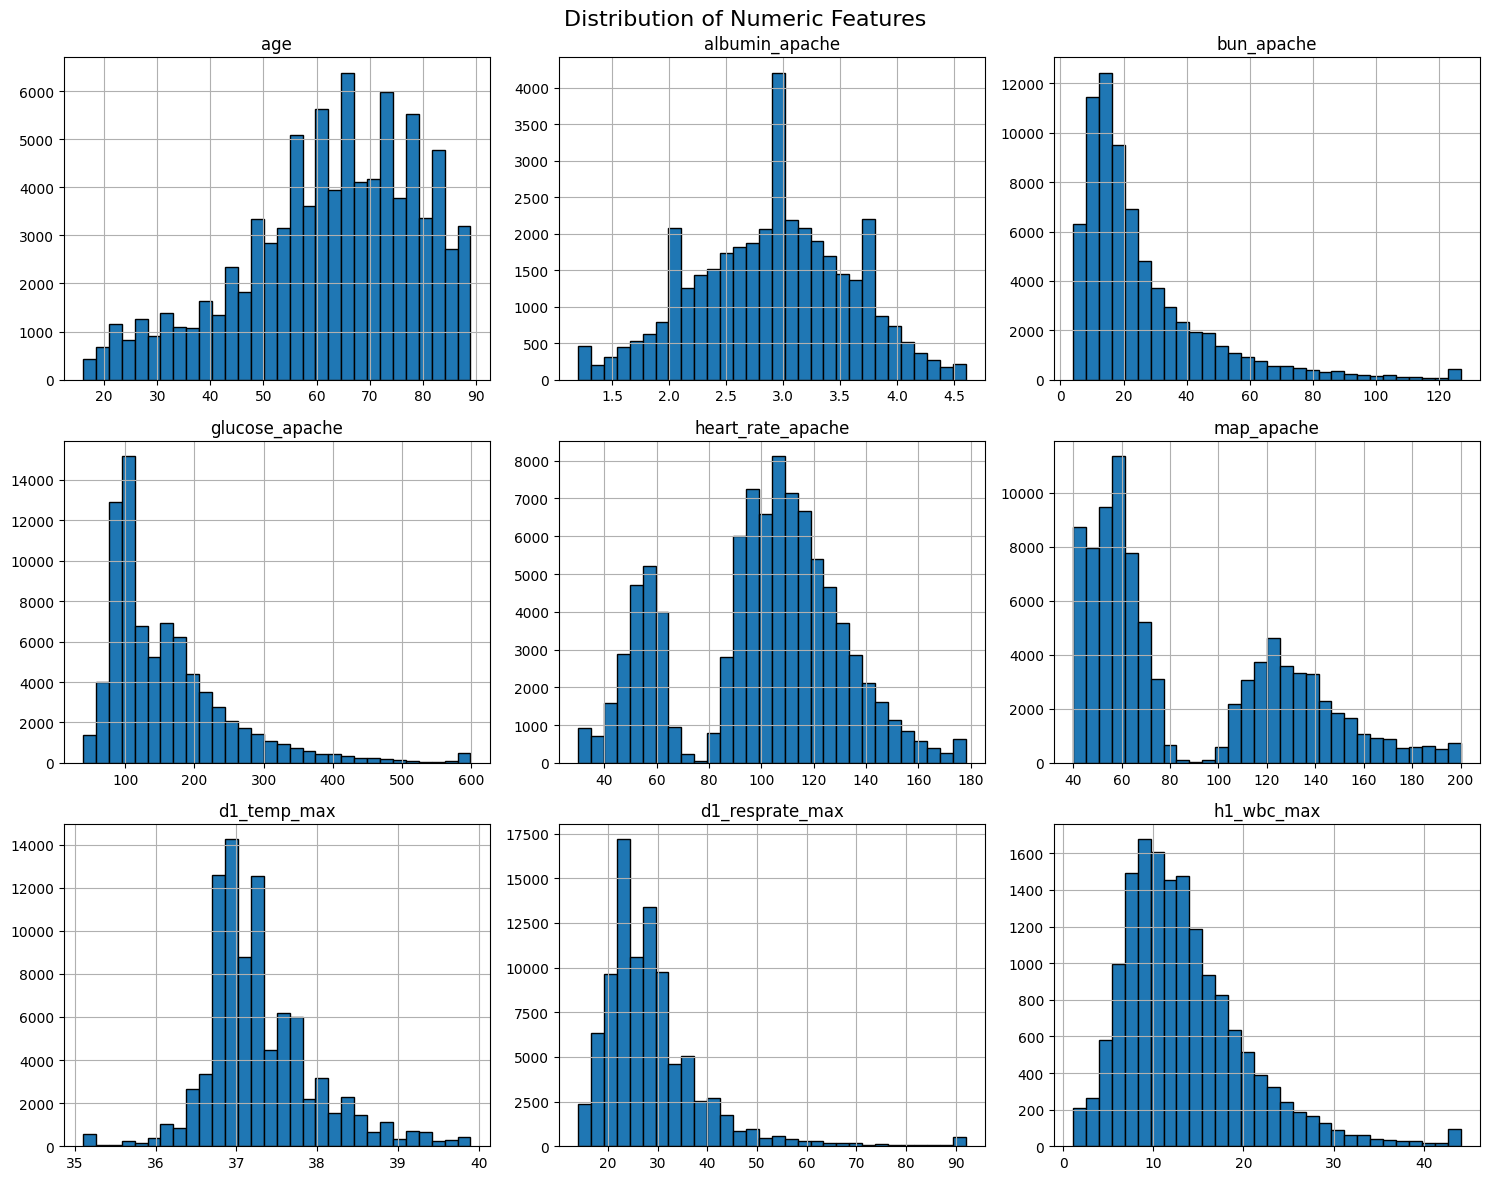

In [7]:
initial_selection = ['age', 'albumin_apache', 'bun_apache', 'glucose_apache', 'heart_rate_apache', 'map_apache', 'd1_temp_max', 'd1_resprate_max', 'h1_wbc_max']
df[initial_selection].hist(figsize=(15, 12), bins=30, edgecolor='black')
plt.suptitle("Distribution of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show();

# 4. Data Issues

## 4.1 Data Missingness 
We first examined the missingness in our dataset. Excluding the response variable `hospital_death`, the dataset contains a total of 185 potential predictors. We performed a preliminary check on the percentage of missing values in each predictor and observed the following:
- 70 predictors have missingness ≤ 5%, where missing data can be imputed relatively confidently using standard imputation methods.
- 33 predictors have missingness between 5% and 20%.
- 82 predictors have missingness > 20%, making imputation more challenging and potentially less reliable.

We also examined data missingness in survived (`'hospital_death' == 0`) and deceased (`'hospital_death' == 1`) populations. The bars for both groups largely overlap at low missingness, suggesting missingness is fairly similar across the two groups for most predictors. At higher missingness, there is a slight difference, but overall it seems the missingness pattern is not drastically different between the groups.

Based on a review of the literature, we decided to select a cutoff value of [???]% to mitigate potential bias that may arise from handling missing data through imputation or alternative methods, depending on the nature of each predictor. The team will further discuss the most appropriate strategy for addressing missing values.

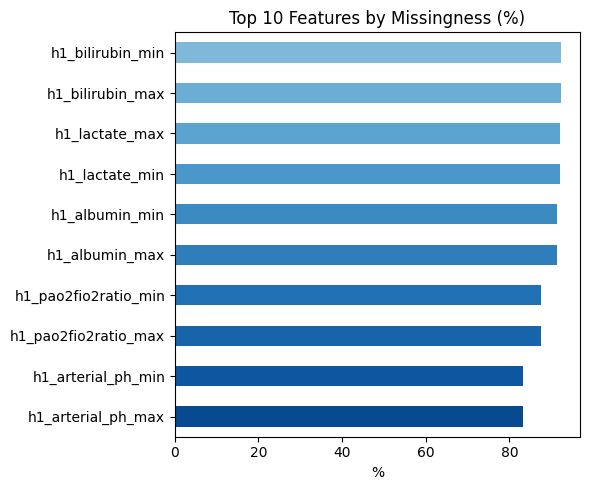

In [8]:
colors = plt.cm.Blues(np.linspace(0.45, 0.9, 10))
na_percent = df.drop(columns=['hospital_death'], errors='ignore').isna().mean()*100
ax = (na_percent.sort_values(ascending=False)
      .head(10)
      .plot(kind='barh', figsize=(6,5), color=colors))
ax.invert_yaxis()
ax.set_title("Top 10 Features by Missingness (%)")
ax.set_xlabel("%")
plt.tight_layout();

Number of predictors with <= 5% missingness: 70
Number of predictors with 5-20% missingness: 33
Number of predictors with > 20% missingness: 82
Percentage of missingness in hospital_death: 0.0


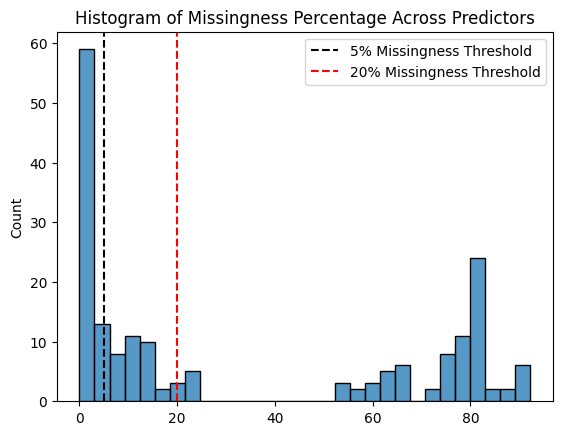

In [9]:
df.isna().sum()

# calculate persontage of missingness for each column
na_percent = df.isna().mean() * 100
na_percent = na_percent.drop('hospital_death') # drop response variable
na_percent = na_percent.sort_values(ascending=True)

# visualize percentage of missingness
fig, ax = plt.subplots()
sns.histplot(na_percent, bins=30, ax=ax)
ax.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax.set_title("Histogram of Missingness Percentage Across Predictors")
ax.legend()

# display stats
print(f'Number of predictors with <= 5% missingness: {sum(na_percent <= 5)}')
print(f'Number of predictors with 5-20% missingness: {sum((na_percent > 5) & (na_percent <= 20))}')
print(f'Number of predictors with > 20% missingness: {sum(na_percent > 20)}')

# calculate % missingness in response
print(f"Percentage of missingness in hospital_death: {df['hospital_death'].isna().mean() * 100}")

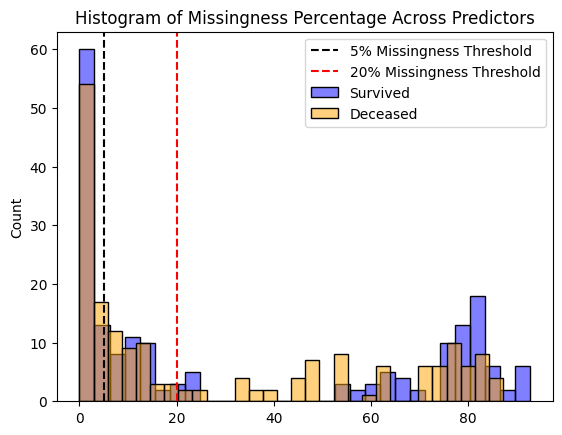

In [11]:
# visualize percentage of missingness by response variable
df_survived = df[df['hospital_death'] == 0]
df_deceased = df[df['hospital_death'] == 1]

fig, ax = plt.subplots()
sns.histplot(df_survived.isna().mean() * 100, bins=30, ax=ax, color='blue', alpha=0.5, label='Survived')
sns.histplot(df_deceased.isna().mean() * 100, bins=30, ax=ax, color='orange', alpha=0.5, label='Deceased')
ax.axvline(x=5, color='k', linestyle='--', label='5% Missingness Threshold')
ax.axvline(x=20, color='red', linestyle='--', label='20% Missingness Threshold')
ax.set_title("Histogram of Missingness Percentage Across Predictors")
ax.legend();

## 4.2 Data Imbalance
We examined the class distribution of our target variable `hospital_death`, and found a significant imbalance: 83,798 patients survived, while 7,915 patients did not. Due to this pronounced imbalance, we decided to incorporate resampling techniques during model training to mitigate its impact and improve the model’s performance on the minority class.

In [12]:
df['hospital_death'].value_counts()

hospital_death
0    83798
1     7915
Name: count, dtype: int64

In [13]:
imbalance_ratio = df['hospital_death'].value_counts(normalize=True)
print(imbalance_ratio)

hospital_death
0    0.913698
1    0.086302
Name: proportion, dtype: float64


## 4.3 Data Scaling
We began by removing all ID-related columns to ensure that identifier values were not treated as quantitative predictors. After doing so, we observed that most features have very small ranges, clustered near zero, while a few features have extremely large ranges (e.g., one reaching ~80,000). This is a classic case of features on widely different scales, meaning some features could dominate model training if not scaled.

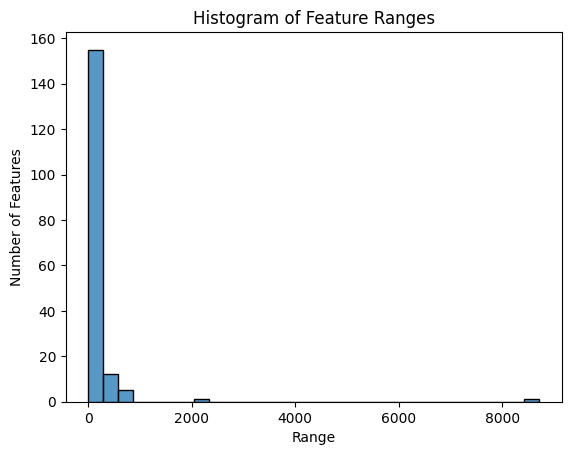

In [14]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.drop(['encounter_id', 'patient_id', 'hospital_id', 'icu_id'])
df[numeric_cols].describe() # exploratory summary

# visualize feature ranges
ranges = df[numeric_cols].max() - df[numeric_cols].min()
fig, ax = plt.subplots()
sns.histplot(ranges, bins=30, edgecolor='k')
ax.set_title("Histogram of Feature Ranges")
ax.set_xlabel("Range")
ax.set_ylabel("Number of Features");

After removing ID-related variables, we examined the distribution of feature ranges to identify differences in scale across numerical predictors. The plot below shows the top 10 features with the largest value ranges.

Key observations:

- **`urineoutput_apache`** has the widest range. According to the data dictionary, this represents urine output prior to ICU admission (used in the APACHE score). Urine output varies widely in critically ill patients, from anuric kidney failure to high-output states, making a large range clinically plausible.

- **`apache_3j_diagnosis`** also shows a large range. This feature represents APACHE diagnostic categories encoded as numeric values. Although it is stored as a number, it functions as a *categorical* variable rather than a continuous physiologic measurement. Its wide numerical spread reflects category codes, not quantitative magnitude. This suggests that additional preprocessing is needed to ensure these encoded values are treated as categorical labels rather than continuous numeric inputs, and to prevent string-like numeric codes without quantitative meaning from influencing model training.

- Several physiologic variables also appear among the largest-range features, including:
  - **PaO₂/FiO₂ ratio** (`d1_pao2fio2ratio_max`, `h1_pao2fio2ratio_max`, `d1_pao2fio2ratio_min`, `h1_pao2fio2ratio_min`), a key indicator of oxygenation
  - **Glucose** (`h1_glucose_max`, `h1_glucose_min`), reflecting metabolic disturbances common in ICU patients
  - **Platelets** (`h1_platelets_min`, `h1_platelets_max`), which can vary due to bleeding, sepsis, or bone marrow dysfunction

These findings highlight substantial variation in feature scales across the dataset. Without proper preprocessing, high-range features may dominate model training. This reinforces the need for feature scaling (e.g., standardization or normalization) to ensure balanced contribution from all variables.

urineoutput_apache      8716.669632
apache_3j_diagnosis     2201.040000
d1_pao2fio2ratio_max     780.005000
h1_pao2fio2ratio_max     678.000000
h1_glucose_max           636.045000
h1_glucose_min           628.000000
h1_pao2fio2ratio_min     616.813793
d1_pao2fio2ratio_min     568.227778
h1_platelets_min         565.000000
h1_platelets_max         565.000000
dtype: float64


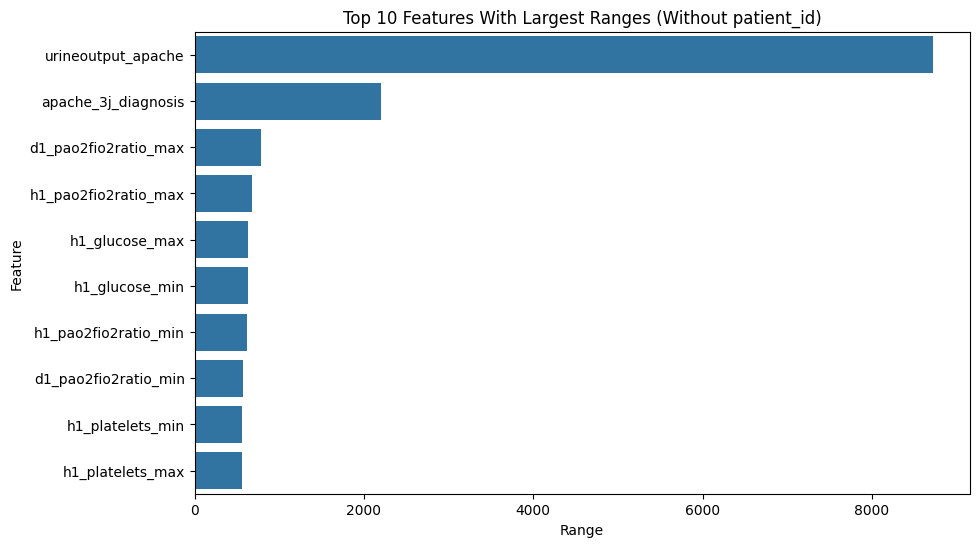

In [15]:
# sort and display
range_sorted = ranges.sort_values(ascending=False)
print(range_sorted.head(10))

# plot top 10 features with largest ranges
plt.figure(figsize=(10,6))
sns.barplot(x=range_sorted.head(10).values, y=range_sorted.head(10).index)
plt.title("Top 10 Features With Largest Ranges (Without patient_id)")
plt.xlabel("Range")
plt.ylabel("Feature")
plt.show();

We also want to examine whether categorical variables exist and how to encode them.

In [16]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("Categorical columns:", list(cat_cols))

Categorical columns: ['ethnicity', 'gender', 'hospital_admit_source', 'icu_admit_source', 'icu_stay_type', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem']


Among our categorical variables, we will retain and encode the following features:
- `ethnicity`  
- `gender`  
- `apache_3j_bodysystem`  
- `apache_2_bodysystem`  
We exclude variables such as `hospital_admit_source`, `icu_admit_source`, `icu_stay_type`, and `icu_type`, as they  primarily capture administrative or operational details and are unlikely to have a direct causal relationship with mortality.

In [17]:
cat_cols = ['ethnicity', 'gender', 'apache_3j_bodysystem', 'apache_2_bodysystem']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
print("Original shape:", df.shape)
print("Encoded shape:", df_encoded.shape)

encoded_cols = [col for col in df_encoded.columns if any(base in col for base in cat_cols)]
print("Example of encoded columns:", encoded_cols[:10])
df_encoded.head()

Original shape: (91713, 186)
Encoded shape: (91713, 207)
Example of encoded columns: ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown', 'gender_M', 'apache_3j_bodysystem_Gastrointestinal', 'apache_3j_bodysystem_Genitourinary', 'apache_3j_bodysystem_Gynecological', 'apache_3j_bodysystem_Hematological']


,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,hospital_admit_source,icu_admit_source,...,apache_3j_bodysystem_Trauma,apache_2_bodysystem_Gastrointestinal,apache_2_bodysystem_Haematologic,apache_2_bodysystem_Metabolic,apache_2_bodysystem_Neurologic,apache_2_bodysystem_Renal/Genitourinary,apache_2_bodysystem_Respiratory,apache_2_bodysystem_Trauma,apache_2_bodysystem_Undefined Diagnoses,apache_2_bodysystem_Undefined diagnoses
0,66154,25312,118,0,68.0,22.73,0,180.3,Floor,Floor,...,False,False,False,False,False,False,False,False,False,False
1,114252,59342,81,0,77.0,27.42,0,160.0,Floor,Floor,...,False,False,False,False,False,False,True,False,False,False
2,119783,50777,118,0,25.0,31.95,0,172.7,Emergency Department,Accident & Emergency,...,False,False,False,True,False,False,False,False,False,False
3,79267,46918,118,0,81.0,22.64,1,165.1,Operating Room,Operating Room / Recovery,...,False,False,False,False,False,False,False,False,False,False
4,92056,34377,33,0,19.0,NaN,0,188.0,NaN,Accident & Emergency,...,True,False,False,False,False,False,False,True,False,False


After one-hot encoding, the dataset expanded from 186 to 207 columns, reflecting the creation of binary indicator variables for the selected categorical features.

## 4.4 Correlation Check
We examined pairwise correlations among numeric predictors to identify potential multicollinearity that could affect interpretability. The heatmap below shows absolute Pearson correlations among the first 15 numeric features with less than 20% missingness (excluding IDs and the label). Some variables show strong positive correlations, indicating redundancy that will be addressed during feature selection.

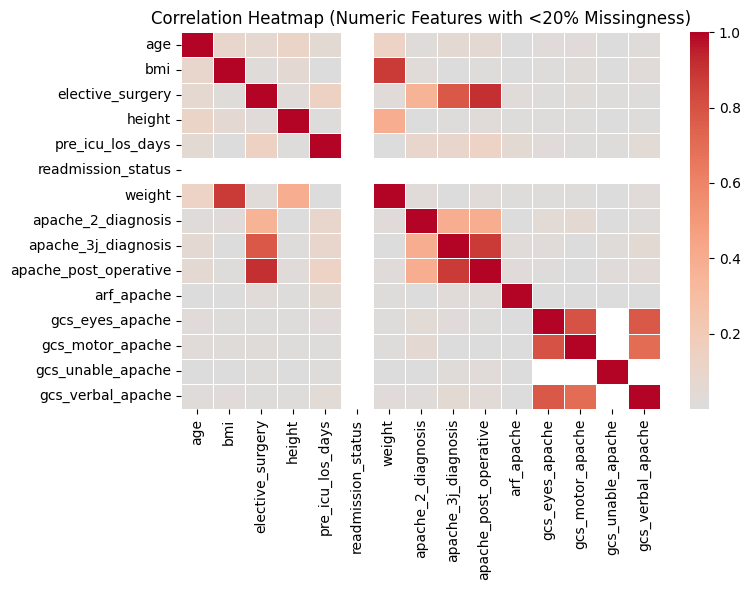

Used 92 / 173 numeric features (<20% missingness).


In [18]:
num_df = (df.select_dtypes(include=['float64', 'int64'])
              .drop(columns=['hospital_death', 'encounter_id', 'patient_id', 'hospital_id', 'icu_id'], errors='ignore'))

low_missing_cols = num_df.columns[num_df.isna().mean() < 0.20].tolist()

corr_matrix_low = num_df[low_missing_cols].corr().abs()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_low.iloc[:15, :15], cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features with <20% Missingness)")
plt.tight_layout()
plt.show();

print(f"Used {len(low_missing_cols)} / {num_df.shape[1]} numeric features (<20% missingness).")